In [1]:
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister, Aer, transpile
from qiskit.visualization import plot_histogram

import random

"""

Reglas Metamórficas implementadas para el algoritmo de Bernstein–Vazirani:

I) Si aplicamos el algoritmo a f_s y f_s1 por separado, donde s1 es el complementario binario de s,
        y luego sumamos ambos resultados, deberíamos obtener el ket |1> de dimensión len(s).
        
II) Si aplicamos el algoritmo a f_s y f_s1 por separado, la suma de ambos resultados, deberíamos obtener s +b s1. 
        Donde (+b) denota la suma bit a bit de cadenas de longitud len(s).

III) Si aplicamos al algoritmo a ambas funciones sucesivamente en estado de superposición, f_s y f_s1,
        se obtiene como resultado s +b s1.
        
"""

def sMT_generator(rule, length):
    # Genera aleatoriamente las cadenas s y s1, para las distintas reglas.
    s = ''
    s1 = ''
    if rule == 1:
        # Para la regla 1, necesitamos que s1 sea el complementario binario de s.
        for i in range(length):
            k = random.randint(0,1)
            s += str(k)
            if k == 0:
                s1 += '1'
            else:
                s1 += '0'
    else:
        for i in range(length):
            k = random.randint(0,1)
            s += str(k)
            k = random.randint(0,1)
            s1 += str(k)
    return s, s1

def bv_fgenerator(length, s): 
    # Genera la puerta f_s/f_s1 para las distintas reglas.      
    qc=QuantumCircuit(length + 1)
    s = s[::-1]
    for q in range(length):
        if s[q] == '0':
            qc.i(q)
        else:
            qc.cx(q, length)
    return qc
            
def sum_bit_to_bit_gate(length): 
    # Devuelve el circuito que realizará la suma bit a bit
    # para dos cadenas de la misma longitud.
    qubits = 3*length + 2
    qc = QuantumCircuit(qubits)
    for i in range(length):
        qc.cx(length - i - 1, qubits - i - 1)
        qc.cx(2*length - i, qubits - i - 1)
    return qc

def bv_testSetUp(rule, qc, length):
    # Añade al circuito las puertas necesarias para finalizar el test
    # de acuerdo a las reglas y toma las mediciones.
    if rule == 3:
        for i in range(length):
            qc.measure(i, i)
    else:
        # Dado que I es un caso particular de II, su finalización es identica.
        suma = sum_bit_to_bit_gate(length)
        sgate = suma.to_gate(label = '  suma  \n bit to bit')
        qc.append(sgate, range(3*length + 2))
        
        for i in range(length):
            qc.measure(2*(length + 1) + i, i)
            
def bv_MT(rule, length):
    # Función que devuelve el circuito cuántico deseado, dada una regla
    # y la longitud deseada
    
    # Generamos las cadenas de bits s y s1
    s,s1 = sMT_generator(rule, length)
    
    # Creamos los nombres para el oráculo que generaremos acorde a cada valor
    # incluyendo el valor de s y s1, que nos permitirá interpretar los resultados.
    
    nameS = '  f_s  \n \ns=' + s
    nameS1 = '  f_s1  \n \ns1=' + s1
    
    # Generamos los oráculos y los convertimos en puerta con el nombre correspondiente.
    f = bv_fgenerator(length,s)
    f_s = f.to_gate(label = nameS)
    
    f1 = bv_fgenerator(length,s1)
    f_s1 = f1.to_gate(label = nameS1)
    
    # Según la regla a estudiar, procederemos a la creación del programa adecuado.
    
    if rule == 3:
        
        # Inicializamos el registro y creamos el circuito.
        # El tamaño se debe a que aplicamos los oráculos de forma consecutiva.
        qs = QuantumRegister(length, 's')
        anc1 = QuantumRegister(1, 'anc1')
        c_test = ClassicalRegister(length, 'c_test')
        qc = QuantumCircuit(qs, anc1, c_test)
        
        # Ponemos los qubits necesarios en superposición
        for i in range(length+1):
            qc.h(i)
        
        # Aplicamos la puerta Z a nuestro qubit ancilla
        qc.z(length)
        qc.barrier()
        
        # Añadimos los oráculos
        qc.append(f_s, range(length + 1))
        qc.barrier()
        
        qc.append(f_s1, range(length + 1))
        qc.barrier()
        
        # Invertimos la superposición ya que H es su propia inversa.
        for i in range(length):
            qc.h(i)
        qc.barrier()
        
    else:
        
        # Inicializamos el registro y creamos el circuito.
        # El tamaño en este caso de suplica ya que aplicamos los oráculos
        #   de forma paralela para su posterior suma.
        qs = QuantumRegister(length, 's')
        anc1 = QuantumRegister(1, 'anc1')
        qs1 = QuantumRegister(length, 's1')
        anc2 = QuantumRegister(1, 'anc2')
        q_test = QuantumRegister(length, 'q_test')
        c_test = ClassicalRegister(length, 'c_test')
        qc = QuantumCircuit(qs, anc1, qs1, anc2, q_test, c_test)
        
        # Ponemos los qubits necesarios en superposición
        for i in range(2*(length+1)):
            qc.h(i)
            
        # Aplicamos la puerta Z a nuestros qubits ancilla, uno para cada oráculo.
        qc.z(length)
        qc.z(2*length + 1)
        qc.barrier()
    
        # Añadimos los oráculos en el lugar adecuado
        qc.append(f_s, range(length + 1))
        qc.append(f_s1, range(length + 1, 2*length + 2))
        qc.barrier()
        
        # Invertimos la superposición.
        for i in range(length):
            qc.h(i)
        for i in range(length + 1, 2*length + 1):
            qc.h(i) 
        qc.barrier()
    
    # Añadimos los elementos restantes para cada regla, ya sea la suma si fuera
    #   necesaria y la medición al registro clásico.
    bv_testSetUp(rule, qc, length)
    
    return qc

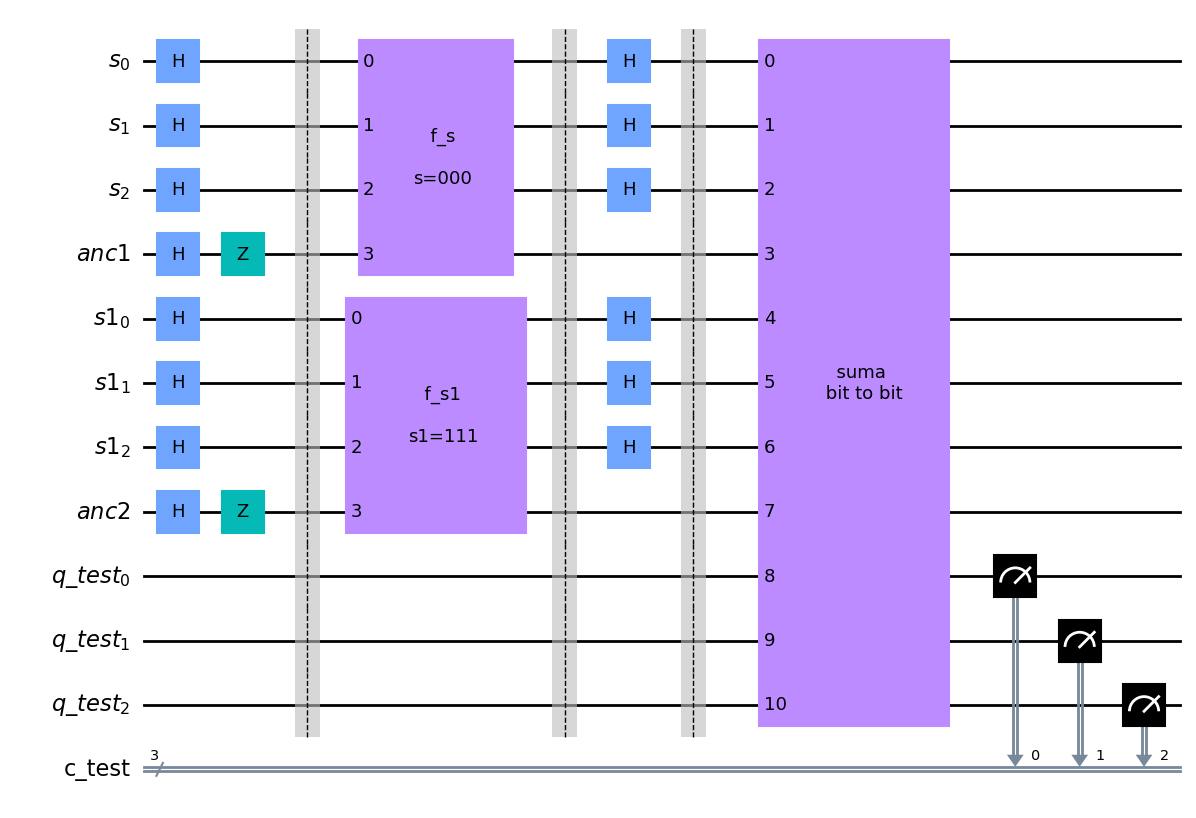

In [2]:
# Test para la regla I: creamos y visualizamos el circuito

test1 = bv_MT(rule = 1, length = 3)
test1.draw(output = 'mpl')

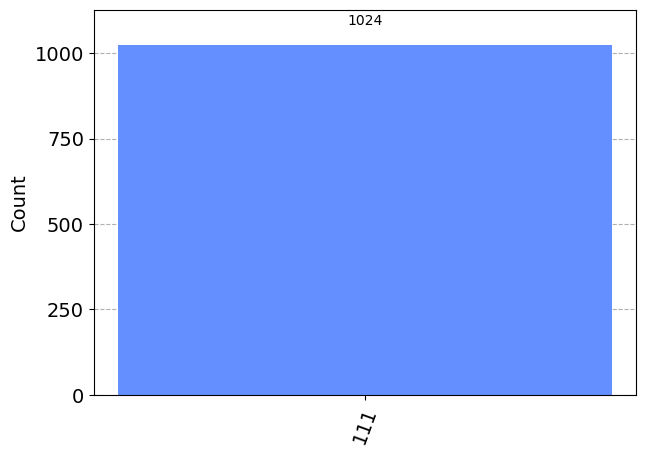

In [3]:
# Simulación teórica del circuito genereado para el test de la regla I
# Resultado esperado: |1>

sim = Aer.get_backend('qasm_simulator')
results = sim.run(transpile(test1, sim)).result()
answer = results.get_counts()
plot_histogram(answer)

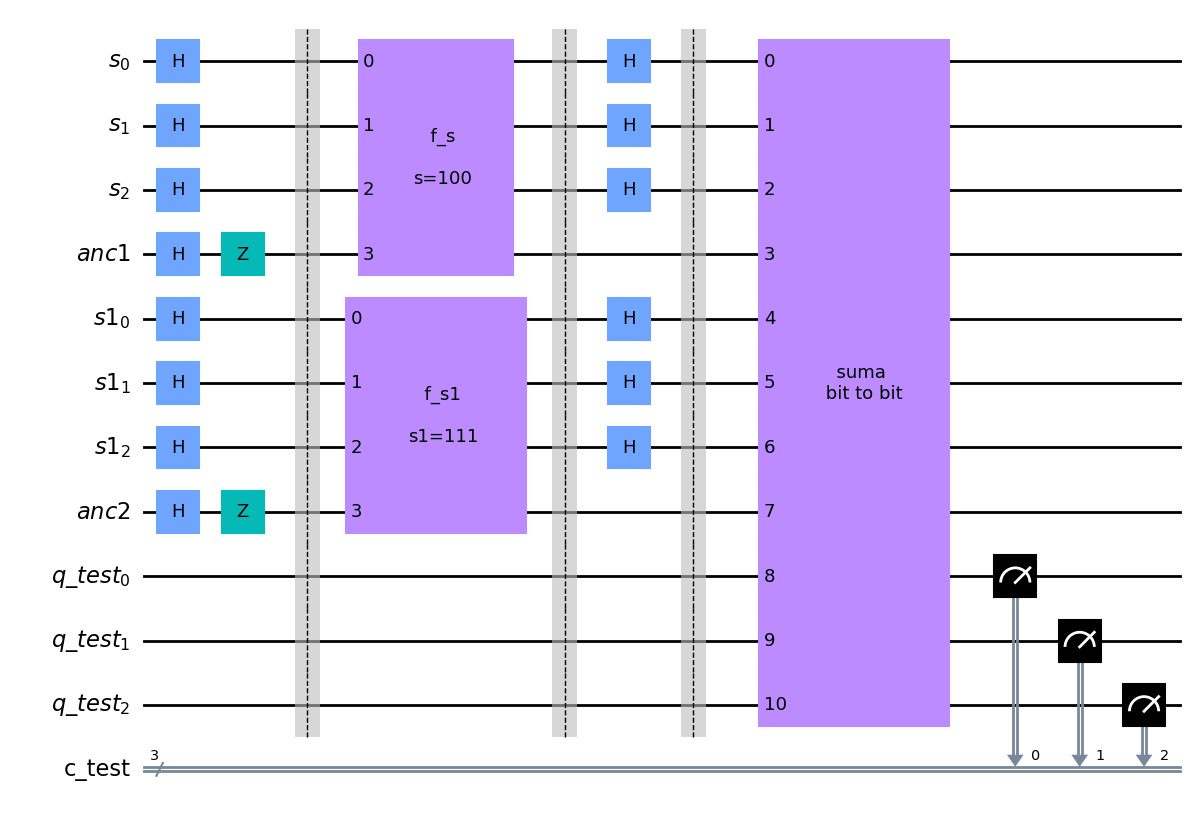

In [4]:
# Test para la regla II: creamos y visualizamos el circuito

test2 = bv_MT(rule = 2, length = 3)
test2.draw(output = 'mpl')

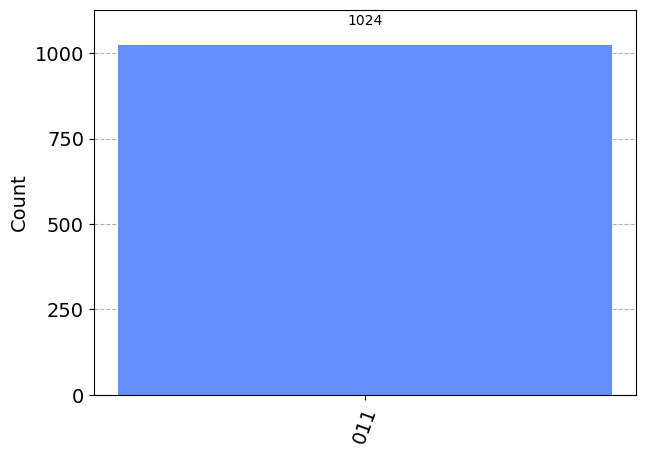

In [5]:
# Simulación teórica del circuito genereado para el test de la regla II
# Resultado esperado: s + s1

sim = Aer.get_backend('qasm_simulator')
results = sim.run(transpile(test2, sim)).result()
answer = results.get_counts()
plot_histogram(answer)

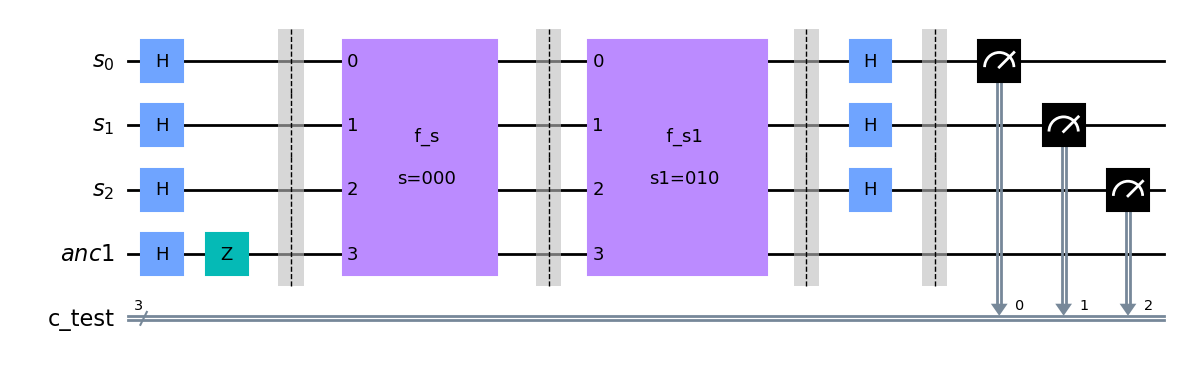

In [6]:
# Test para la regla III: creamos y visualizamos el circuito

test3 = bv_MT(rule = 3, length = 3)
test3.draw(output='mpl')

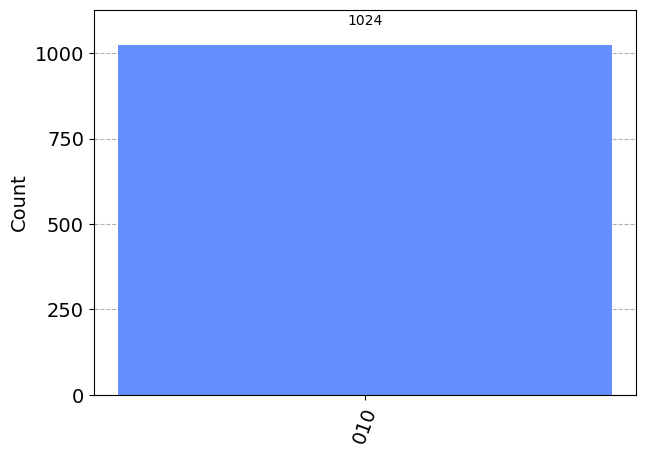

In [7]:
# Simulación teórica del circuito genereado para el test de la regla III
# Resultado esperado: s + s1

sim = Aer.get_backend('qasm_simulator')
results = sim.run(transpile(test3, sim)).result()
answer = results.get_counts()
plot_histogram(answer)